# Project: Identify Customer Segments

In this project, you will apply unsupervised learning techniques to identify segments of the population that form the core customer base for a mail-order sales company in Germany. These segments can then be used to direct marketing campaigns towards audiences that will have the highest expected rate of returns. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

This notebook will help you complete this task by providing a framework within which you will perform your analysis steps. In each step of the project, you will see some text describing the subtask that you will perform, followed by one or more code cells for you to complete your work. **Feel free to add additional code and markdown cells as you go along so that you can explore everything in precise chunks.** The code cells provided in the base template will outline only the major tasks, and will usually not be enough to cover all of the minor tasks that comprise it.

It should be noted that while there will be precise guidelines on how you should handle certain tasks in the project, there will also be places where an exact specification is not provided. **There will be times in the project where you will need to make and justify your own decisions on how to treat the data.** These are places where there may not be only one way to handle the data. In real-life tasks, there may be many valid ways to approach an analysis task. One of the most important things you can do is clearly document your approach so that other scientists can understand the decisions you've made.

At the end of most sections, there will be a Markdown cell labeled **Discussion**. In these cells, you will report your findings for the completed section, as well as document the decisions that you made in your approach to each subtask. **Your project will be evaluated not just on the code used to complete the tasks outlined, but also your communication about your observations and conclusions at each stage.**

In [1]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from helper_functions_p import int2words
from sklearn.cluster import KMeans
# magic word for producing visualizations in notebook
%matplotlib inline

#ignore all warnings
#import warnings
#warnings.filterwarnings('ignore')

### Step 0: Load the Data

There are four files associated with this project (not including this one):

- `Udacity_AZDIAS_Subset.csv`: Demographics data for the general population of Germany; 891211 persons (rows) x 85 features (columns).
- `Udacity_CUSTOMERS_Subset.csv`: Demographics data for customers of a mail-order company; 191652 persons (rows) x 85 features (columns).
- `Data_Dictionary.md`: Detailed information file about the features in the provided datasets.
- `AZDIAS_Feature_Summary.csv`: Summary of feature attributes for demographics data; 85 features (rows) x 4 columns

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. You will use this information to cluster the general population into groups with similar demographic properties. Then, you will see how the people in the customers dataset fit into those created clusters. The hope here is that certain clusters are over-represented in the customers data, as compared to the general population; those over-represented clusters will be assumed to be part of the core userbase. This information can then be used for further applications, such as targeting for a marketing campaign.

To start off with, load in the demographics data for the general population into a pandas DataFrame, and do the same for the feature attributes summary. Note for all of the `.csv` data files in this project: they're semicolon (`;`) delimited, so you'll need an additional argument in your [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call to read in the data properly. Also, considering the size of the main dataset, it may take some time for it to load completely.

Once the dataset is loaded, it's recommended that you take a little bit of time just browsing the general structure of the dataset and feature summary file. You'll be getting deep into the innards of the cleaning in the first major step of the project, so gaining some general familiarity can help you get your bearings.

In [2]:
# Load in the general demographics data.
azdias = pd.read_csv('Udacity_AZDIAS_Subset.csv',sep=';')

# Load in the feature summary file.
feat_info = pd.read_csv('AZDIAS_Feature_Summary.csv',sep=';')

a) Shows the structure of Demographic Data

In [3]:
# Check the structure of the data after it's loaded (e.g. print the number of rows and columns, print the first few rows).
print("There are {} rows and {} columns in General Demographic Data".format(azdias.shape[0],azdias.shape[1]))
print("-----------------------------------------------------------")
print("This is how General Demographic Data looks like")
azdias.head()

There are 891221 rows and 85 columns in General Demographic Data
-----------------------------------------------------------
This is how General Demographic Data looks like


,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,-1,2,1,2.0,3,4,3,5,5,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,-1,1,2,5.0,1,5,2,5,4,5,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,-1,3,2,3.0,1,4,1,2,3,5,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,2,4,2,2.0,4,2,5,2,1,2,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,-1,3,1,5.0,4,3,4,1,3,2,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0


b) Shows the structure of Feature Summary Data

In [4]:
print("There are {} rows and {} columns in Feature Summary file".format(feat_info.shape[0],feat_info.shape[1]))
print("-----------------------------------------------------------")
print("This is how Feature Summary file looks like")
feat_info.head()

There are 85 rows and 4 columns in Feature Summary file
-----------------------------------------------------------
This is how Feature Summary file looks like


,attribute,information_level,type,missing_or_unknown
0,AGER_TYP,person,categorical,"[-1,0]"
1,ALTERSKATEGORIE_GROB,person,ordinal,"[-1,0,9]"
2,ANREDE_KZ,person,categorical,"[-1,0]"
3,CJT_GESAMTTYP,person,categorical,[0]
4,FINANZ_MINIMALIST,person,ordinal,[-1]


> **Tip**: Add additional cells to keep everything in reasonably-sized chunks! Keyboard shortcut `esc --> a` (press escape to enter command mode, then press the 'A' key) adds a new cell before the active cell, and `esc --> b` adds a new cell after the active cell. If you need to convert an active cell to a markdown cell, use `esc --> m` and to convert to a code cell, use `esc --> y`. 

## Step 1: Preprocessing

### Step 1.1: Assess Missing Data

The feature summary file contains a summary of properties for each demographics data column. You will use this file to help you make cleaning decisions during this stage of the project. First of all, you should assess the demographics data in terms of missing data. Pay attention to the following points as you perform your analysis, and take notes on what you observe. Make sure that you fill in the **Discussion** cell with your findings and decisions at the end of each step that has one!

#### Step 1.1.1: Convert Missing Value Codes to NaNs
The fourth column of the feature attributes summary (loaded in above as `feat_info`) documents the codes from the data dictionary that indicate missing or unknown data. While the file encodes this as a list (e.g. `[-1,0]`), this will get read in as a string object. You'll need to do a little bit of parsing to make use of it to identify and clean the data. Convert data that matches a 'missing' or 'unknown' value code into a numpy NaN value. You might want to see how much data takes on a 'missing' or 'unknown' code, and how much data is naturally missing, as a point of interest.

**As one more reminder, you are encouraged to add additional cells to break up your analysis into manageable chunks.**

a) First get the NaN values count for each column before conversion

In [5]:
azdias_NaN_Before_conversion = azdias.isnull().sum()
azdias_NaN_Before_conversion[:10]

AGER_TYP                    0
ALTERSKATEGORIE_GROB        0
ANREDE_KZ                   0
CJT_GESAMTTYP            4854
FINANZ_MINIMALIST           0
FINANZ_SPARER               0
FINANZ_VORSORGER            0
FINANZ_ANLEGER              0
FINANZ_UNAUFFAELLIGER       0
FINANZ_HAUSBAUER            0
dtype: int64

b) Before converting missing_or_unknown values to NaN, lets see these missing or unknown values for some of the columns

In [6]:
azdias.query('AGER_TYP in [-1,0]').head()

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,-1,2,1,2.0,3,4,3,5,5,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,-1,1,2,5.0,1,5,2,5,4,5,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,-1,3,2,3.0,1,4,1,2,3,5,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
4,-1,3,1,5.0,4,3,4,1,3,2,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0
6,-1,2,2,5.0,1,5,1,5,4,3,...,3.0,3.0,1.0,0.0,1.0,5.0,5.0,4.0,6.0,3.0


c) Convert missing data to NaNs

In [7]:
# Identify missing or unknown data values and convert them to NaNs.

#this line will create the data dictionary of missing_or_unknown values for each column so that these values can be
#transformed from string to a list of values with corresponding data types
feat_missing_dict = feat_info.set_index('attribute')['missing_or_unknown'].to_dict()
#miss count will contain the count of missing_or_unknown values for each column
miss_count =[]

#Below loop does two things: 1) convert the missing_or_unknown values to NaN 2) Get the count of such missing_or_unknown values in each column
for cols in azdias.columns:
    feat_missing_dict[cols] = feat_missing_dict.get(cols).strip("[]").split(',')
    count = 0
    
    for i in feat_missing_dict[cols]:
        if len(i):
            try:
                if int(i) or int(i) == 0:
                    i = int(i)
            except: 
                None
            count += np.sum(azdias[cols] == i)
            azdias[cols] = np.where(azdias[cols] == i,np.nan,azdias[cols])
    miss_count.append(count)

d) Just to verify whether above conversion worked or not, lets check the same query again

In [8]:
azdias.query('AGER_TYP in [-1,0]').head()

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB


**And Yes, conversion of missing or unknown values to NaNs worked**

e) Let's create a dataframe which will have count of missing_or_unknown values and NaN values

In [9]:
azdias_missing_NaN = feat_info[['attribute']]
azdias_missing_NaN['NaN_Before_Convert'] = azdias_NaN_Before_conversion.values
azdias_missing_NaN['missing_or_unknown'] = miss_count
azdias_missing_NaN['Nan_After_Conversion'] = azdias.isnull().sum().values
azdias_missing_NaN['NaN_%percetage'] = azdias_missing_NaN['Nan_After_Conversion']/azdias.shape[0] * 100
azdias_missing_NaN.head()

E:\Anaconda\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
E:\Anaconda\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,attribute,NaN_Before_Convert,missing_or_unknown,Nan_After_Conversion,NaN_%percetage
0,AGER_TYP,0,685843,685843,76.955435
1,ALTERSKATEGORIE_GROB,0,2881,2881,0.323264
2,ANREDE_KZ,0,0,0,0.000000
3,CJT_GESAMTTYP,4854,0,4854,0.544646
4,FINANZ_MINIMALIST,0,0,0,0.000000


#### Step 1.1.2: Assess Missing Data in Each Column

How much missing data is present in each column? There are a few columns that are outliers in terms of the proportion of values that are missing. You will want to use matplotlib's [`hist()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.hist.html) function to visualize the distribution of missing value counts to find these columns. Identify and document these columns. While some of these columns might have justifications for keeping or re-encoding the data, for this project you should just remove them from the dataframe. (Feel free to make remarks about these outlier columns in the discussion, however!)

For the remaining features, are there any patterns in which columns have, or share, missing data?

a) As the count of missing values has been computed so draw the count through a plot

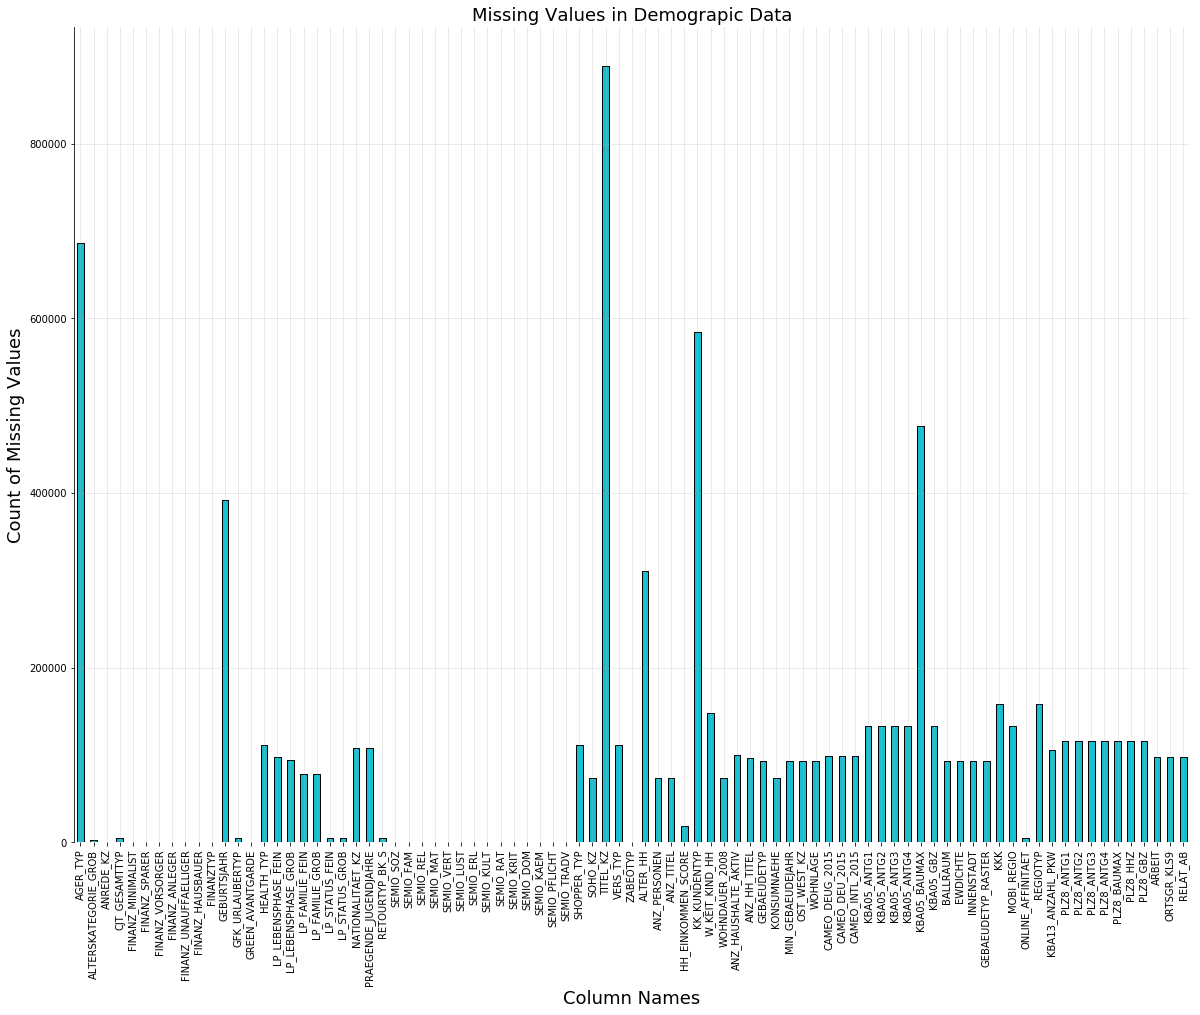

In [10]:
# Perform an assessment of how much missing data there is in each column of the dataset.

ax = azdias_missing_NaN.plot(x='attribute', y='Nan_After_Conversion', kind='bar', figsize=(20,15), color='#17becf', edgecolor='black', legend=None)
ax.set_title('Missing Values in Demograpic Data', fontsize=18)
ax.set_xlabel('Column Names', fontsize=18)
ax.set_ylabel('Count of Missing Values', fontsize=18)
sns.despine(bottom=True)
plt.grid(True, alpha=0.3)

In [11]:
# Investigate patterns in the amount of missing data in each column.
print("Personal Level Details")
print(azdias_missing_NaN.loc[:42,['attribute','Nan_After_Conversion','NaN_%percetage']])
print("--------------------------------------------------------------------")
print("Household Level Details")
print(azdias_missing_NaN.loc[43:49,['attribute','Nan_After_Conversion','NaN_%percetage']])
print("--------------------------------------------------------------------")
print("Building Level Details")
print(azdias_missing_NaN.loc[50:56,['attribute','Nan_After_Conversion','NaN_%percetage']])
print("--------------------------------------------------------------------")
print("RR4 Micro Level Details")
print(azdias_missing_NaN.loc[57:59,['attribute','Nan_After_Conversion','NaN_%percetage']])
print("--------------------------------------------------------------------")
print("RR3 Micro Level Details")
print(azdias_missing_NaN.loc[60:65,['attribute','Nan_After_Conversion','NaN_%percetage']])
print("--------------------------------------------------------------------")
print("Postcode Level Details")
print(azdias_missing_NaN.loc[66:68,['attribute','Nan_After_Conversion','NaN_%percetage']])
print("--------------------------------------------------------------------")
print("RR1 Region Level Details")
print(azdias_missing_NaN.loc[69:73,['attribute','Nan_After_Conversion','NaN_%percetage']])
print("--------------------------------------------------------------------")
print("PLZ8 Macro Level Details")
print(azdias_missing_NaN.loc[74:81,['attribute','Nan_After_Conversion','NaN_%percetage']])
print("--------------------------------------------------------------------")
print("Community Level Details")
print(azdias_missing_NaN.loc[82:84,['attribute','Nan_After_Conversion','NaN_%percetage']])
print("--------------------------------------------------------------------")

Personal Level Details
                attribute  Nan_After_Conversion  NaN_%percetage
0                AGER_TYP                685843       76.955435
1    ALTERSKATEGORIE_GROB                  2881        0.323264
2               ANREDE_KZ                     0        0.000000
3           CJT_GESAMTTYP                  4854        0.544646
4       FINANZ_MINIMALIST                     0        0.000000
5           FINANZ_SPARER                     0        0.000000
6        FINANZ_VORSORGER                     0        0.000000
7          FINANZ_ANLEGER                     0        0.000000
8   FINANZ_UNAUFFAELLIGER                     0        0.000000
9        FINANZ_HAUSBAUER                     0        0.000000
10              FINANZTYP                     0        0.000000
11            GEBURTSJAHR                392318       44.020282
12        GFK_URLAUBERTYP                  4854        0.544646
13       GREEN_AVANTGARDE                     0        0.000000
14             HE

In [12]:
#check columns with zero missing values
print("There are {} columns with zero missing values".format(azdias_missing_NaN['attribute'][azdias_missing_NaN['NaN_%percetage'] == 0].count()))

There are 24 columns with zero missing values


Let's consider the threshold to be 30% i.e. drop any column which is having more than 30% NaN values

In [13]:
# Remove the outlier columns from the dataset. (You'll perform other data
# engineering tasks such as re-encoding and imputation later.)
feat_info_reduced = feat_info.copy()
print('Following are the columns being dropped as they are having more than 30% NaN values')
#contain the list of columns which are being dropped from Demographics Data
azdias_cols_dropped = []
for index, val in enumerate(azdias_missing_NaN['NaN_%percetage']):
    if val > 30:
        cols = azdias_missing_NaN.iloc[index,0]
        azdias.drop(cols,inplace=True, axis=1)
        feat_info_reduced.drop(feat_info[feat_info['attribute'] == cols].index[0], inplace=True, axis=0)
        print(cols)
        azdias_cols_dropped.append(cols)
feat_info_reduced.reset_index(inplace=True)

Following are the columns being dropped as they are having more than 30% NaN values
AGER_TYP
GEBURTSJAHR
TITEL_KZ
ALTER_HH
KK_KUNDENTYP
KBA05_BAUMAX


In [14]:
#cross-check the result in azdias dataset
azdias.shape

(891221, 79)

#### Discussion 1.1.2: Assess Missing Data in Each Column

Upon analysing the missing values in each column based on their groups, following is the conclusion: <br>

Except Personal Level Details and Household details, there is not much variance in the count of missing values in columns of each group.

##### 1) Person Level Details:
Most of the personal level features does not have any missing value that means. The columns which do have more missing values i.e Date of birth or title, it seems most of the people did not provide these details intentionally. 

##### 2) Household Level Details:
In this group, some features are having same number of missing values. But some features like birthdate so many people does not want to share their DOB and Consumer pattern which might be unavailable. 

##### 3) Building-level Details:
The count of missing values is not same in each columns but they have very low variance so most probably most of the details are missing for same group of people.

##### 4) RR4 Micro Level Details:
All the features in this group have same number of missing values so seems like these details are missing for same type of people.

##### 5) RR3 micro-cell Level Details:
All the features except KBA05_BAUMAX(Most common building type within the microcell) in this group have same number of missing values so seems like these details are missing for same type of people.

And about Most common building type, looks like some of the areas does not have any building.

##### 6) Postcode Level Details:
All the features in this group have same number of missing values so seems like these details are missing for same type of people.

##### 7) RR1 region Level Details:
I think most important feature in this group is Online affinity which does not have any missing value.

##### 8) PLZ8 macro-cell Details:
All the columns have almost same number of missing values except KBA13_ANZAHL_PKW(Number of cars in the PLZ8 region) i.e. there are some people who did not provide the car details or they don't have cars.
##### 9) Community Level Details:
All the columns have almost same number of missing values that means same group of people did not provide these details.

#### Step 1.1.3: Assess Missing Data in Each Row

Now, you'll perform a similar assessment for the rows of the dataset. How much data is missing in each row? As with the columns, you should see some groups of points that have a very different numbers of missing values. Divide the data into two subsets: one for data points that are above some threshold for missing values, and a second subset for points below that threshold.

In order to know what to do with the outlier rows, we should see if the distribution of data values on columns that are not missing data (or are missing very little data) are similar or different between the two groups. Select at least five of these columns and compare the distribution of values.
- You can use seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) function to create a bar chart of code frequencies and matplotlib's [`subplot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.subplot.html) function to put bar charts for the two subplots side by side.
- To reduce repeated code, you might want to write a function that can perform this comparison, taking as one of its arguments a column to be compared.

Depending on what you observe in your comparison, this will have implications on how you approach your conclusions later in the analysis. If the distributions of non-missing features look similar between the data with many missing values and the data with few or no missing values, then we could argue that simply dropping those points from the analysis won't present a major issue. On the other hand, if the data with many missing values looks very different from the data with few or no missing values, then we should make a note on those data as special. We'll revisit these data later on. **Either way, you should continue your analysis for now using just the subset of the data with few or no missing values.**

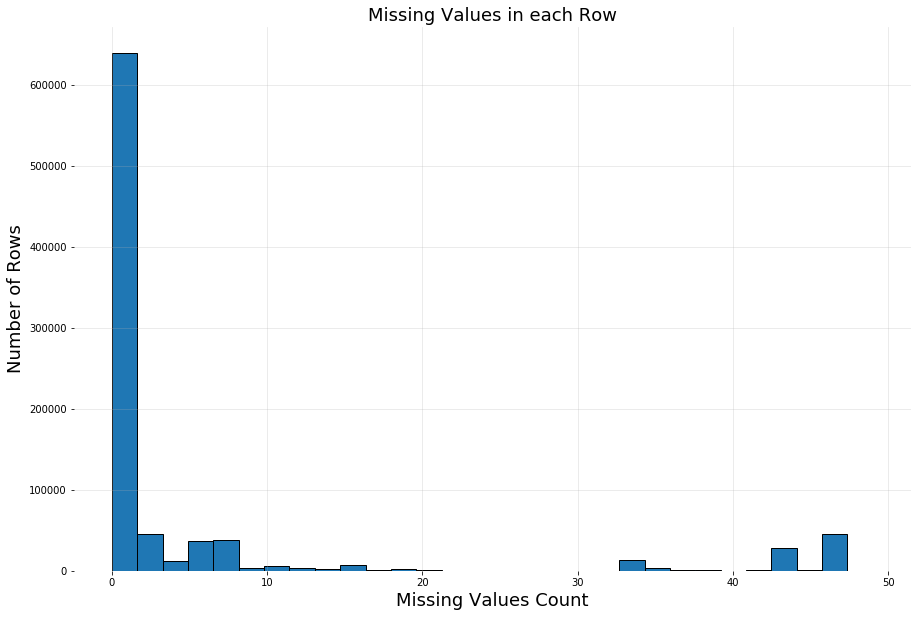

In [15]:
# How much data is missing in each row of the dataset?
ax = azdias.isnull().sum(axis=1).plot(kind='hist',bins=30, figsize=(15,10), edgecolor='black')
sns.despine(left=True, bottom=True)
ax.set_title('Missing Values in each Row', fontsize=18)
ax.set_xlabel('Missing Values Count', fontsize=18)
ax.set_ylabel('Number of Rows', fontsize=18)
plt.grid(True, alpha=0.3)


In [28]:
# Write code to divide the data into two subsets based on the number of missing
# values in each row.
set_threshold = 0
print("Threshold to divide the data into two subsets based on missing rows is set to {}".format(set_threshold))
azdias_subset_1 = azdias[azdias.isnull().sum(axis=1) == set_threshold].copy()
azdias_subset_2 = azdias[azdias.isnull().sum(axis=1) > set_threshold].copy()
print("First subset is having {} rows and Second subset is having {} rows which is about {} and {} data respectively".format(azdias_subset_1.shape[0], azdias_subset_2.shape[0],azdias_subset_1.shape[0]/azdias.shape[0] * 100, azdias_subset_2.shape[0]/azdias.shape[0] * 100))

Threshold to divide the data into two subsets based on missing rows is set to 0
First subset is having 623209 rows and Second subset is having 268012 rows which is about 69.9275488346886 and 30.07245116531141 data respectively


In [40]:
np.sort(azdias.isnull().sum()/azdias.shape[0] * 100)

array([ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.32326438,
        0.54464605,  0.54464605,  0.54464605,  0.54464605,  0.54464605,
        0.54464605,  2.05874862,  8.24700046,  8.24700046,  8.24700046,
        8.24700046,  8.2997371 ,  8.72869917,  8.72869917, 10.45172858,
       10.45172858, 10.45172858, 10.45172858, 10.45251402, 10.51815431,
       10.51815431, 10.51815431, 10.61150938, 10.88484226, 10.91468895,
       10.92602172, 10.92602172, 10.95485856, 11.14785222, 11.14785222,
       11.14785222, 11.17691347, 11.87135402, 12.13660809, 12.15355114,
       12.47681551, 12.47681551, 12.47681551, 13.07363718, 13.07363718,
       13.07363718, 13.07363718, 13.07363718, 13.07363718, 13.07

As we can see that the missing value range varies from 0% to 17.73% so to pick 5 columns we can pick one columns from the following ranges: 

**a)** 0-1% : ANREDE_KZ, FINANZTYP, ONLINE_AFFINITAET, GFK_URLAUBERTYP

**b)** 1-10% : HH_EINKOMMEN_SCORE, KONSUMNAEHE, LP_FAMILIE_FEIN

**c)** 10-12% : ARBEIT, KBA13_ANZAHL_PKW, LP_LEBENSPHASE_FEIN, CAMEO_DEUG_2015

**d)** 12-15% : SHOPPER_TYP, KBA05_ANTG1, PLZ8_ANTG1

**e)** 15-18% : REGIOTYP, W_KEIT_KIND_HH

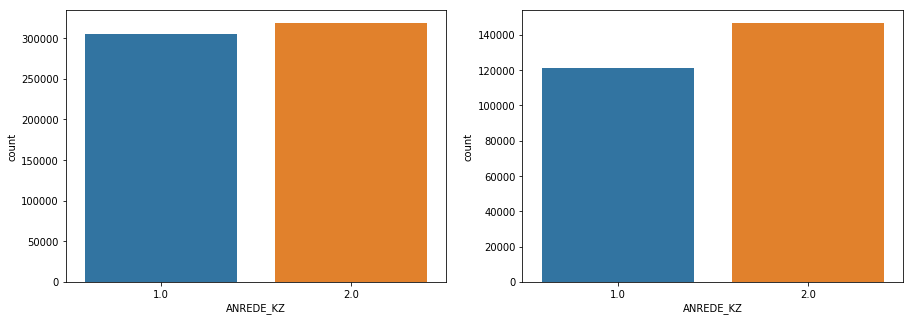

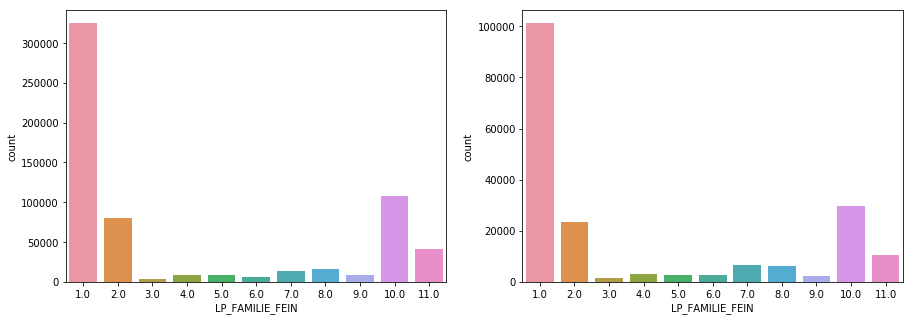

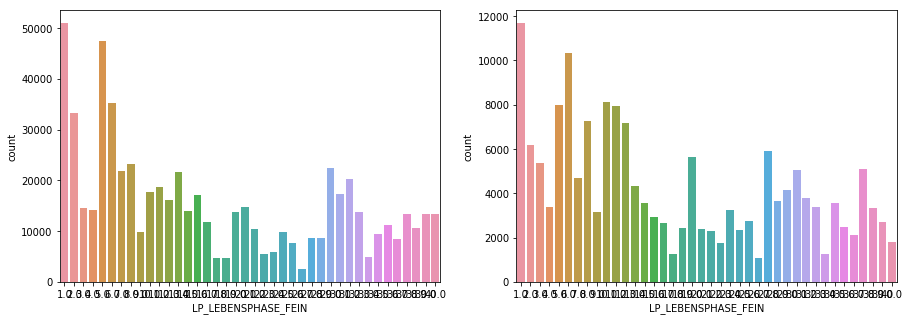

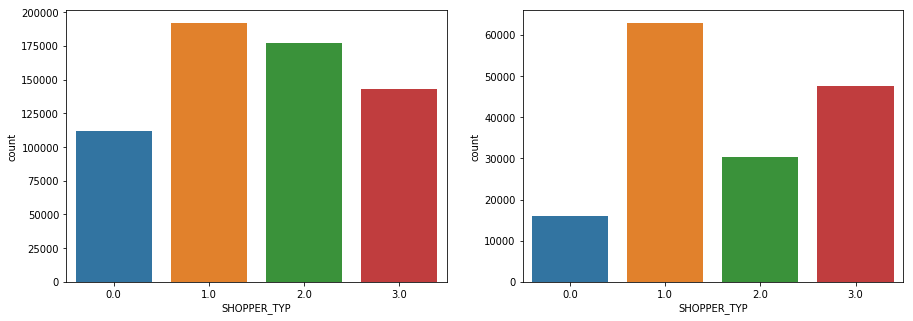

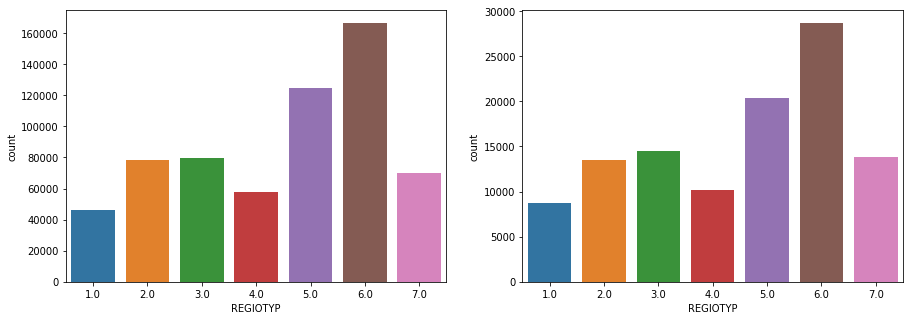

In [42]:
# Compare the distribution of values for at least five columns where there are
# no or few missing values, between the two subsets.

def comp_plot_columns(col):
    fig, axr = plt.subplots(1,2, figsize=(15,5))
    sns.countplot(azdias_subset_1[col],ax=axr[0])
    sns.countplot(azdias_subset_2[col],ax=axr[1])

comp_plot_columns('ANREDE_KZ')
comp_plot_columns('LP_FAMILIE_FEIN')
comp_plot_columns('LP_LEBENSPHASE_FEIN')
comp_plot_columns('SHOPPER_TYP')
comp_plot_columns('REGIOTYP')

#### Discussion 1.1.3: Assess Missing Data in Each Row

I have divided the above plots in 5 categories such as - 0-1%, 1-10%, 10-12%, 12-15% and 15-18%.

As we can see for most of the features, data with lots of missing values is qualitatively similar to the data with no missing values so we can safely remove those rows from the dataset and hence threshold for rows is 0.

Note: It is not possible for all the features to have same distribution but those details can be analysed later with more domain knowledge as why there are missing values and what is the best way to fill those details because most of the features are either categorical, nominal or ordinal.

### Step 1.2: Select and Re-Encode Features

Checking for missing data isn't the only way in which you can prepare a dataset for analysis. Since the unsupervised learning techniques to be used will only work on data that is encoded numerically, you need to make a few encoding changes or additional assumptions to be able to make progress. In addition, while almost all of the values in the dataset are encoded using numbers, not all of them represent numeric values. Check the third column of the feature summary (`feat_info`) for a summary of types of measurement.
- For numeric and interval data, these features can be kept without changes.
- Most of the variables in the dataset are ordinal in nature. While ordinal values may technically be non-linear in spacing, make the simplifying assumption that the ordinal variables can be treated as being interval in nature (that is, kept without any changes).
- Special handling may be necessary for the remaining two variable types: categorical, and 'mixed'.

In the first two parts of this sub-step, you will perform an investigation of the categorical and mixed-type features and make a decision on each of them, whether you will keep, drop, or re-encode each. Then, in the last part, you will create a new data frame with only the selected and engineered columns.

Data wrangling is often the trickiest part of the data analysis process, and there's a lot of it to be done here. But stick with it: once you're done with this step, you'll be ready to get to the machine learning parts of the project!

In [43]:
# How many features are there of each data type?

print("Following table shows the count of each type of features\n")
print(feat_info_reduced.groupby('type')['type'].count())
print("-------------------------------------------------------------------\n")
print("Following are the categorical featues\n")
cat_variable = azdias_subset_1[feat_info_reduced[feat_info_reduced['type'] == 'categorical']['attribute']] 
print(cat_variable.info())

Following table shows the count of each type of features

type
categorical    18
mixed           6
numeric         6
ordinal        49
Name: type, dtype: int64
-------------------------------------------------------------------

Following are the categorical featues

<class 'pandas.core.frame.DataFrame'>
Int64Index: 623209 entries, 1 to 891220
Data columns (total 18 columns):
ANREDE_KZ           623209 non-null float64
CJT_GESAMTTYP       623209 non-null float64
FINANZTYP           623209 non-null float64
GFK_URLAUBERTYP     623209 non-null float64
GREEN_AVANTGARDE    623209 non-null int64
LP_FAMILIE_FEIN     623209 non-null float64
LP_FAMILIE_GROB     623209 non-null float64
LP_STATUS_FEIN      623209 non-null float64
LP_STATUS_GROB      623209 non-null float64
NATIONALITAET_KZ    623209 non-null float64
SHOPPER_TYP         623209 non-null float64
SOHO_KZ             623209 non-null float64
VERS_TYP            623209 non-null float64
ZABEOTYP            623209 non-null float64
GEBAEUD

#### Step 1.2.1: Re-Encode Categorical Features

For categorical data, you would ordinarily need to encode the levels as dummy variables. Depending on the number of categories, perform one of the following:
- For binary (two-level) categoricals that take numeric values, you can keep them without needing to do anything.
- There is one binary variable that takes on non-numeric values. For this one, you need to re-encode the values as numbers or create a dummy variable.
- For multi-level categoricals (three or more values), you can choose to encode the values using multiple dummy variables (e.g. via [OneHotEncoder](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html)), or (to keep things straightforward) just drop them from the analysis. As always, document your choices in the Discussion section.

In [48]:
# Assess categorical variables: which are binary, which are multi-level, and
# which one needs to be re-encoded?

bin_list = [] 
multi_list = [] 
for t in cat_variable: 
    if len(cat_variable[t].value_counts()) == 2: 
        bin_list.append(t) 
    else: 
        multi_list.append(t)

print("Binary variables are\n",bin_list)
print("Multi-label variables are\n",multi_list)

Binary variables are
 ['ANREDE_KZ', 'GREEN_AVANTGARDE', 'SOHO_KZ', 'VERS_TYP', 'OST_WEST_KZ']
Multi-label variables are
 ['CJT_GESAMTTYP', 'FINANZTYP', 'GFK_URLAUBERTYP', 'LP_FAMILIE_FEIN', 'LP_FAMILIE_GROB', 'LP_STATUS_FEIN', 'LP_STATUS_GROB', 'NATIONALITAET_KZ', 'SHOPPER_TYP', 'ZABEOTYP', 'GEBAEUDETYP', 'CAMEO_DEUG_2015', 'CAMEO_DEU_2015']


In [248]:
cat_variable[bin_list].head()

,ANREDE_KZ,GREEN_AVANTGARDE,SOHO_KZ,VERS_TYP,OST_WEST_KZ
1,2.0,0,1.0,2.0,W
2,2.0,1,0.0,1.0,W
4,1.0,0,0.0,2.0,W
5,2.0,0,0.0,2.0,W
6,2.0,0,0.0,1.0,W


In [45]:
# Re-encode categorical variable(s) to be kept in the analysis.

azdias_cat_onehot = cat_variable.copy()
azdias_cat_onehot.replace({'OST_WEST_KZ':{'O':0,'W':1}}, inplace=True)
azdias_cat_onehot = pd.get_dummies(azdias_cat_onehot,columns=multi_list, prefix=multi_list)

azdias_cat_onehot.head()

,ANREDE_KZ,GREEN_AVANTGARDE,SOHO_KZ,VERS_TYP,OST_WEST_KZ,CJT_GESAMTTYP_1.0,CJT_GESAMTTYP_2.0,CJT_GESAMTTYP_3.0,CJT_GESAMTTYP_4.0,CJT_GESAMTTYP_5.0,...,CAMEO_DEU_2015_7E,CAMEO_DEU_2015_8A,CAMEO_DEU_2015_8B,CAMEO_DEU_2015_8C,CAMEO_DEU_2015_8D,CAMEO_DEU_2015_9A,CAMEO_DEU_2015_9B,CAMEO_DEU_2015_9C,CAMEO_DEU_2015_9D,CAMEO_DEU_2015_9E
1,2.0,0,1.0,2.0,1,0,0,0,0,1,...,0,1,0,0,0,0,0,0,0,0
2,2.0,1,0.0,1.0,1,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1.0,0,0.0,2.0,1,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
5,2.0,0,0.0,2.0,1,0,1,0,0,0,...,0,0,0,1,0,0,0,0,0,0
6,2.0,0,0.0,1.0,1,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0


#### Discussion 1.2.1: Re-Encode Categorical Features

I filtered out all the categorical variables from the features category dataset. Then, separate out the binary and multi-label features.

In Binary features, there was OST_WEST_KZ (Building location east/west germany) variable which had non-numeric values so converted 'E' to 0 and 'W' to 1. Other binary variables are left unchanged.

For Multi-label features, did one hot encoding because these features looks promising to determine the cluster because these are mostly personal level features regarding their status, habits etc.

#### Step 1.2.2: Engineer Mixed-Type Features

There are a handful of features that are marked as "mixed" in the feature summary that require special treatment in order to be included in the analysis. There are two in particular that deserve attention; the handling of the rest are up to your own choices:
- "PRAEGENDE_JUGENDJAHRE" combines information on three dimensions: generation by decade, movement (mainstream vs. avantgarde), and nation (east vs. west). While there aren't enough levels to disentangle east from west, you should create two new variables to capture the other two dimensions: an interval-type variable for decade, and a binary variable for movement.
- "CAMEO_INTL_2015" combines information on two axes: wealth and life stage. Break up the two-digit codes by their 'tens'-place and 'ones'-place digits into two new ordinal variables (which, for the purposes of this project, is equivalent to just treating them as their raw numeric values).
- If you decide to keep or engineer new features around the other mixed-type features, make sure you note your steps in the Discussion section.

Be sure to check `Data_Dictionary.md` for the details needed to finish these tasks.

In [46]:
# Investigate "PRAEGENDE_JUGENDJAHRE" and engineer two new variables.
PRAEGENDE_JUGENDJAHRE_DECADE = azdias_subset_1['PRAEGENDE_JUGENDJAHRE'].copy()
PRAEGENDE_JUGENDJAHRE_DECADE.replace({1:40,2:40,3:50,4:50,5:60,6:60,7:60,8:70,9:70,10:80,11:80,12:80,13:80,14:90,15:90}, inplace=True)
azdias_cat_onehot['PRAEGENDE_JUGENDJAHRE_DECADE'] = PRAEGENDE_JUGENDJAHRE_DECADE

PRAEGENDE_JUGENDJAHRE_MOVEMENT = azdias_subset_1['PRAEGENDE_JUGENDJAHRE'].copy()
PRAEGENDE_JUGENDJAHRE_MOVEMENT.replace({1:0,2:1,3:0,4:1,5:0,6:1,7:1,8:0,9:1,10:0,11:1,12:0,13:1,14:0,15:1}, inplace=True)
azdias_cat_onehot['PRAEGENDE_JUGENDJAHRE_MOVEMENT'] = PRAEGENDE_JUGENDJAHRE_MOVEMENT

In [47]:
# Investigate "CAMEO_INTL_2015" and engineer two new variables.

CAMEO_INTL_WEALTH =[]
CAMEO_INTL_LIFE_STAGE =[]
for i in azdias_subset_1['CAMEO_INTL_2015']:
    CAMEO_INTL_WEALTH.append(int(i[0]))
    CAMEO_INTL_LIFE_STAGE.append(int(i[1]))
azdias_cat_onehot['CAMEO_INTL_WEALTH'] = CAMEO_INTL_WEALTH
azdias_cat_onehot['CAMEO_INTL_LIFE_STAGE'] = CAMEO_INTL_LIFE_STAGE

#### Discussion 1.2.2: Engineer Mixed-Type Features

In total, there are 7 mixed features such as - LP_LEBENSPHASE_FEIN, LP_LEBENSPHASE_GROB, PRAEGENDE_JUGENDJAHRE, WOHNLAGE, CAMEO_INTL_2015, KBA05_BAUMAX and PLZ8_BAUMAX

I engineered only two mixed features i.e PRAEGENDE_JUGENDJAHRE and CAMEO_INTL_2015 and added these along with categorical features.

LP_LEBENSPHASE_FEIN and LP_LEBENSPHASE_GROB have been further described by LP_FAMILIE_FEIN and LP_FAMILIE_GROB so no need to do any engineering into these features, thought, these two can be removed but these just put more description on family status so left it as it is.

WOHNLAGE could have been converted into binary variable such as rural area or not. But as this looks more like a ordinal features so lets keep it that way.

KBA05_BAUMAX and PLZ8_BAUMAX can also be treated as ordinal so keep them as it is.

#### Step 1.2.3: Complete Feature Selection

In order to finish this step up, you need to make sure that your data frame now only has the columns that you want to keep. To summarize, the dataframe should consist of the following:
- All numeric, interval, and ordinal type columns from the original dataset.
- Binary categorical features (all numerically-encoded).
- Engineered features from other multi-level categorical features and mixed features.

Make sure that for any new columns that you have engineered, that you've excluded the original columns from the final dataset. Otherwise, their values will interfere with the analysis later on the project. For example, you should not keep "PRAEGENDE_JUGENDJAHRE", since its values won't be useful for the algorithm: only the values derived from it in the engineered features you created should be retained. As a reminder, your data should only be from **the subset with few or no missing values**.

In [255]:
# If there are other re-engineering tasks you need to perform, make sure you
# take care of them here. (Dealing with missing data will come in step 2.1.)
azdias_subset_1.drop(columns=cat_variable.columns.values, axis=1, inplace=True)
azdias_subset_1.drop(columns=['PRAEGENDE_JUGENDJAHRE','CAMEO_INTL_2015'], axis=1, inplace=True)

azdias_final_df = pd.concat([azdias_subset_1,azdias_cat_onehot],axis=1)

In [257]:
# Do whatever you need to in order to ensure that the dataframe only contains
# the columns that should be passed to the algorithm functions.

azdias_final_df.head()

,ALTERSKATEGORIE_GROB,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,HEALTH_TYP,LP_LEBENSPHASE_FEIN,LP_LEBENSPHASE_GROB,...,CAMEO_DEU_2015_8D,CAMEO_DEU_2015_9A,CAMEO_DEU_2015_9B,CAMEO_DEU_2015_9C,CAMEO_DEU_2015_9D,CAMEO_DEU_2015_9E,PRAEGENDE_JUGENDJAHRE_DECADE,PRAEGENDE_JUGENDJAHRE_MOVEMENT,CAMEO_INTL_WEALTH,CAMEO_INTL_LIFE_STAGE
1,1.0,1.0,5.0,2.0,5.0,4.0,5.0,3.0,21.0,6.0,...,0,0,0,0,0,0,90.0,0.0,5,1
2,3.0,1.0,4.0,1.0,2.0,3.0,5.0,3.0,3.0,1.0,...,0,0,0,0,0,0,90.0,1.0,2,4
4,3.0,4.0,3.0,4.0,1.0,3.0,2.0,3.0,32.0,10.0,...,0,0,0,0,0,0,70.0,0.0,4,3
5,1.0,3.0,1.0,5.0,2.0,2.0,5.0,3.0,8.0,2.0,...,0,0,0,0,0,0,50.0,0.0,5,4
6,2.0,1.0,5.0,1.0,5.0,4.0,3.0,2.0,2.0,1.0,...,0,0,0,0,0,0,80.0,0.0,2,2


### Step 1.3: Create a Cleaning Function

Even though you've finished cleaning up the general population demographics data, it's important to look ahead to the future and realize that you'll need to perform the same cleaning steps on the customer demographics data. In this substep, complete the function below to execute the main feature selection, encoding, and re-engineering steps you performed above. Then, when it comes to looking at the customer data in Step 3, you can just run this function on that DataFrame to get the trimmed dataset in a single step.

In [258]:
def clean_data(df, test_train, columns_deleted=[]):
    """
    Perform feature trimming, re-encoding, and engineering for demographics
    data
    
    INPUT: Demographics DataFrame
    OUTPUT: Trimmed and cleaned demographics DataFrame
    """
    
    # Put in code here to execute all main cleaning steps:
    # convert missing value codes into NaNs, ...
    
    feat_missing_dict = feat_info.set_index('attribute')['missing_or_unknown'].to_dict()
    #miss count will contain the count of missing_or_unknown values for each column
    miss_count =[]

    #Below loop does two things: 1) convert the missing_or_unknown values to NaN 2) Get the count of such missing_or_unknown values in each column
    for cols in df.columns:
        feat_missing_dict[cols] = feat_missing_dict.get(cols).strip("[]").split(',')
        count = 0
    
        for i in feat_missing_dict[cols]:
            if len(i):
                try:
                    if int(i) or int(i) == 0:
                        i = int(i)
                except: 
                    None
                count += np.sum(df[cols] == i)
                df[cols] = np.where(df[cols] == i,np.nan,df[cols])
        miss_count.append(count)
    
    # remove selected columns and rows, ...
    NaN_percentage = df.isnull().sum().values/df.shape[0] * 100
    feat_info_reduced = feat_info.copy()
    print('Following are the columns being dropped as they are having more than 30% NaN values')
    if test_train == 'train':
        columns_deleted = []
        for index, val in enumerate(NaN_percentage):
            if val > 30:
                cols = feat_info.iloc[index,0]
                print(cols)
                columns_deleted.append(cols)
                df.drop(cols,inplace=True, axis=1)
                feat_info_reduced.drop(feat_info_reduced[feat_info_reduced['attribute'] == cols].index[0], inplace=True, axis=0)
        feat_info_reduced.reset_index(inplace=True)
    else:
        for index, val in enumerate(NaN_percentage):
            if val > 30:
                cols = feat_info.iloc[index,0]
                if cols in columns_deleted:
                    df.drop(cols,inplace=True, axis=1)
                    feat_info_reduced.drop(feat_info_reduced[feat_info_reduced['attribute'] == cols].index[0], inplace=True, axis=0)
                    print(cols)
        feat_info_reduced.reset_index(inplace=True)
    
    # select, re-encode, and engineer column values.
    set_threshold = 0
    print("Threshold to divide the data into two subsets based on missing rows is {}".format(set_threshold))
    df_subset_1 = df[df.isnull().sum(axis=1) == set_threshold].copy()
    df_subset_2 = df[df.isnull().sum(axis=1) > set_threshold].copy()
    print("First subset is having {} rows and Second subset is having {} rows which is about {} and {} data respectively".format(df_subset_1.shape[0], df_subset_2.shape[0],df_subset_1.shape[0]/df.shape[0] * 100, df_subset_2.shape[0]/df.shape[0] * 100))
          
    print("Following table shows the count of each type of features\n")
    print(feat_info_reduced.groupby('type')['type'].count())
    print("-------------------------------------------------------------------\n")
    print("Following are the categorical featues\n")
    cat_variable = df_subset_1[feat_info_reduced[feat_info_reduced['type'] == 'categorical']['attribute']] 
    print(cat_variable.info())
    
    # Assess categorical variables: which are binary, which are multi-level, and
    # which one needs to be re-encoded?

    bin_list = [] 
    multi_list = [] 
    for t in cat_variable: 
        if len(cat_variable[t].value_counts()) == 2: 
            bin_list.append(t) 
        else: 
            multi_list.append(t)

    print("Binary variables are\n",bin_list)
    print("Multi-level variables are\n",multi_list)
    
    #cat_list =[]
    #for i in cat_variable.select_dtypes(include=['object']).columns.values:
    #    if i in multi_list:
    #        cat_list.append(i)
    
    df_cat_onehot = cat_variable.copy()    
    df_cat_onehot.replace({'OST_WEST_KZ':{'O':0,'W':1}}, inplace=True)
    df_cat_onehot = pd.get_dummies(df_cat_onehot,columns=multi_list, prefix=multi_list)
    
    PRAEGENDE_JUGENDJAHRE_DECADE = df_subset_1['PRAEGENDE_JUGENDJAHRE'].copy()
    PRAEGENDE_JUGENDJAHRE_DECADE.replace({1:40,2:40,3:50,4:50,5:60,6:60,7:60,8:70,9:70,10:80,11:80,12:80,13:80,14:90,15:90}, inplace=True)
    df_cat_onehot['PRAEGENDE_JUGENDJAHRE_DECADE'] = PRAEGENDE_JUGENDJAHRE_DECADE

    PRAEGENDE_JUGENDJAHRE_MOVEMENT = df_subset_1['PRAEGENDE_JUGENDJAHRE'].copy()
    PRAEGENDE_JUGENDJAHRE_MOVEMENT.replace({1:0,2:1,3:0,4:1,5:0,6:1,7:1,8:0,9:1,10:0,11:1,12:0,13:1,14:0,15:1}, inplace=True)
    df_cat_onehot['PRAEGENDE_JUGENDJAHRE_MOVEMENT'] = PRAEGENDE_JUGENDJAHRE_MOVEMENT
    
    # Investigate "CAMEO_INTL_2015" and engineer two new variables.

    CAMEO_INTL_WEALTH =[]
    CAMEO_INTL_LIFE_STAGE =[]
    for i in df_subset_1['CAMEO_INTL_2015']:
        CAMEO_INTL_WEALTH.append(int(i[0]))
        CAMEO_INTL_LIFE_STAGE.append(int(i[1]))
    df_cat_onehot['CAMEO_INTL_WEALTH'] = CAMEO_INTL_WEALTH
    df_cat_onehot['CAMEO_INTL_LIFE_STAGE'] = CAMEO_INTL_LIFE_STAGE
    
    # Return the cleaned dataframe.
    df_subset_1.drop(columns=cat_variable.columns.values, axis=1, inplace=True)
    df_subset_1.drop(columns=['PRAEGENDE_JUGENDJAHRE','CAMEO_INTL_2015'], axis=1, inplace=True)


    df = pd.concat([df_subset_1,df_cat_onehot],axis=1)
    if test_train == 'train':
        return df, columns_deleted
    else:
        return df

In [259]:
# Load in the general demographics data.
azdias = pd.read_csv('Udacity_AZDIAS_Subset.csv',sep=';')
general, columns_deleted = clean_data(azdias, 'train')
general.head()

Following are the columns being dropped as they are having more than 30% NaN values
AGER_TYP
GEBURTSJAHR
TITEL_KZ
ALTER_HH
KK_KUNDENTYP
KBA05_BAUMAX
Threshold to divide the data into two subsets based on missing rows is 0
First subset is having 623209 rows and Second subset is having 268012 rows which is about 69.9275488346886 and 30.07245116531141 data respectively
Following table shows the count of each type of features

type
categorical    18
mixed           6
numeric         6
ordinal        49
Name: type, dtype: int64
-------------------------------------------------------------------

Following are the categorical featues

<class 'pandas.core.frame.DataFrame'>
Int64Index: 623209 entries, 1 to 891220
Data columns (total 18 columns):
ANREDE_KZ           623209 non-null float64
CJT_GESAMTTYP       623209 non-null float64
FINANZTYP           623209 non-null float64
GFK_URLAUBERTYP     623209 non-null float64
GREEN_AVANTGARDE    623209 non-null int64
LP_FAMILIE_FEIN     623209 non-nul

,ALTERSKATEGORIE_GROB,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,HEALTH_TYP,LP_LEBENSPHASE_FEIN,LP_LEBENSPHASE_GROB,...,CAMEO_DEU_2015_8D,CAMEO_DEU_2015_9A,CAMEO_DEU_2015_9B,CAMEO_DEU_2015_9C,CAMEO_DEU_2015_9D,CAMEO_DEU_2015_9E,PRAEGENDE_JUGENDJAHRE_DECADE,PRAEGENDE_JUGENDJAHRE_MOVEMENT,CAMEO_INTL_WEALTH,CAMEO_INTL_LIFE_STAGE
1,1.0,1.0,5.0,2.0,5.0,4.0,5.0,3.0,21.0,6.0,...,0,0,0,0,0,0,90.0,0.0,5,1
2,3.0,1.0,4.0,1.0,2.0,3.0,5.0,3.0,3.0,1.0,...,0,0,0,0,0,0,90.0,1.0,2,4
4,3.0,4.0,3.0,4.0,1.0,3.0,2.0,3.0,32.0,10.0,...,0,0,0,0,0,0,70.0,0.0,4,3
5,1.0,3.0,1.0,5.0,2.0,2.0,5.0,3.0,8.0,2.0,...,0,0,0,0,0,0,50.0,0.0,5,4
6,2.0,1.0,5.0,1.0,5.0,4.0,3.0,2.0,2.0,1.0,...,0,0,0,0,0,0,80.0,0.0,2,2


## Step 2: Feature Transformation

### Step 2.1: Apply Feature Scaling

Before we apply dimensionality reduction techniques to the data, we need to perform feature scaling so that the principal component vectors are not influenced by the natural differences in scale for features. Starting from this part of the project, you'll want to keep an eye on the [API reference page for sklearn](http://scikit-learn.org/stable/modules/classes.html) to help you navigate to all of the classes and functions that you'll need. In this substep, you'll need to check the following:

- sklearn requires that data not have missing values in order for its estimators to work properly. So, before applying the scaler to your data, make sure that you've cleaned the DataFrame of the remaining missing values. This can be as simple as just removing all data points with missing data, or applying an [Imputer](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.Imputer.html) to replace all missing values. You might also try a more complicated procedure where you temporarily remove missing values in order to compute the scaling parameters before re-introducing those missing values and applying imputation. Think about how much missing data you have and what possible effects each approach might have on your analysis, and justify your decision in the discussion section below.
- For the actual scaling function, a [StandardScaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) instance is suggested, scaling each feature to mean 0 and standard deviation 1.
- For these classes, you can make use of the `.fit_transform()` method to both fit a procedure to the data as well as apply the transformation to the data at the same time. Don't forget to keep the fit sklearn objects handy, since you'll be applying them to the customer demographics data towards the end of the project.

In [ ]:
# If you've not yet cleaned the dataset of all NaN values, then investigate and
# do that now.



In [260]:
# Apply feature scaling to the general population demographics data.

scalar = StandardScaler()
general_scalar_fit = scalar.fit(general)
general_scalar_transform = scalar.fit_transform(general)

### Discussion 2.1: Apply Feature Scaling

I had already removed all the NaN rows from the dataset so I did not have any missing value in the general dataset and so did not use Imputer to fill the missing.

I have used StandardScalar to do the scaling.

### Step 2.2: Perform Dimensionality Reduction

On your scaled data, you are now ready to apply dimensionality reduction techniques.

- Use sklearn's [PCA](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) class to apply principal component analysis on the data, thus finding the vectors of maximal variance in the data. To start, you should not set any parameters (so all components are computed) or set a number of components that is at least half the number of features (so there's enough features to see the general trend in variability).
- Check out the ratio of variance explained by each principal component as well as the cumulative variance explained. Try plotting the cumulative or sequential values using matplotlib's [`plot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.plot.html) function. Based on what you find, select a value for the number of transformed features you'll retain for the clustering part of the project.
- Once you've made a choice for the number of components to keep, make sure you re-fit a PCA instance to perform the decided-on transformation.

In [269]:
def do_pca(n_components, data):
    '''
    Transforms data using PCA to create n_components, and provides back the results of the
    transformation.

    INPUT: n_components - int - the number of principal components to create
           data - the data you would like to transform

    OUTPUT: pca - the pca object created after fitting the data
            X_pca - the transformed X matrix with new number of components
    '''
    pca = PCA(n_components)
    X_pca = pca.fit_transform(data)
    return pca, X_pca

In [272]:
for comp in range(50,120):
    pca, X_pca = do_pca(comp,general_scalar_transform)
    if np.sum(pca.explained_variance_ratio_) > 0.85:
        print('{} compenents are needed to reach atleast 85%'.format(comp))
        break
num_comps = comp

93 compenents are needed to reach atleast 85%


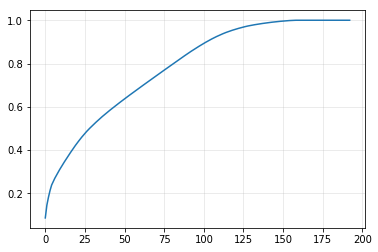

In [273]:
# Investigate the variance accounted for by each principal component.

pca = PCA()
X = pca.fit(general_scalar_transform)
ratio = np.cumsum(X.explained_variance_ratio_)
pd.Series(ratio).plot()
plt.grid(True, alpha=0.3)

In [274]:
# Re-apply PCA to the data while selecting for number of components to retain.

pca = PCA(n_components=115)
general_pca_fit = pca.fit(general_scalar_transform)
general_pca_transform = pca.fit_transform(general_scalar_transform)

### Discussion 2.2: Perform Dimensionality Reduction

After apply PCA on scaled data, we can see that atleast 93 components are required to reach 85% variablity. 

I am planning to retain 115 components as it represents around 95% variance.

### Step 2.3: Interpret Principal Components

Now that we have our transformed principal components, it's a nice idea to check out the weight of each variable on the first few components to see if they can be interpreted in some fashion.

As a reminder, each principal component is a unit vector that points in the direction of highest variance (after accounting for the variance captured by earlier principal components). The further a weight is from zero, the more the principal component is in the direction of the corresponding feature. If two features have large weights of the same sign (both positive or both negative), then increases in one tend expect to be associated with increases in the other. To contrast, features with different signs can be expected to show a negative correlation: increases in one variable should result in a decrease in the other.

- To investigate the features, you should map each weight to their corresponding feature name, then sort the features according to weight. The most interesting features for each principal component, then, will be those at the beginning and end of the sorted list. Use the data dictionary document to help you understand these most prominent features, their relationships, and what a positive or negative value on the principal component might indicate.
- You should investigate and interpret feature associations from the first three principal components in this substep. To help facilitate this, you should write a function that you can call at any time to print the sorted list of feature weights, for the *i*-th principal component. This might come in handy in the next step of the project, when you interpret the tendencies of the discovered clusters.

In [275]:
#function to map the weight
def pca_map_weights(pca, comp, df):
    components = pd.Series(np.round(pca.components_[comp-1],4), index=df.keys())
    print("Explained variance for 1 Dimension - %.4f \n"%(np.round(pca.explained_variance_ratio_[comp-1],4)))
    print("Following are the linked values in sorted order (descending): \n")
    components_sorted = components.sort_values(ascending=False)
    print(components_sorted)
    components_sorted_first_10 = components_sorted[:10]
    components_sorted_last_10 = components_sorted[-10:]
    components_sorted_s = components_sorted_first_10.append(components_sorted_last_10)
    
    fig, ax = plt.subplots(figsize = (14,8))
    components_sorted_s.plot(ax = ax, kind = 'bar');
    ax.set_ylabel("Feature Weights")
    t_text = 'Top 10 and Bottom 10 Weights for the ' +int2words(comp)+ ' Principal Component'
    ax.set_title(t_text, fontsize=18)
    for p in ax.patches:
        ax.annotate(np.round(p.get_height(),decimals=4), (p.get_x()+p.get_width()/2., p.get_height()), ha='center', va='center', xytext=(0, 10), textcoords='offset points')
   

Explained variance for 1 Dimension - 0.0865 

Following are the linked values in sorted order (descending): 

LP_STATUS_GROB_1.0                0.1859
HH_EINKOMMEN_SCORE                0.1753
CAMEO_INTL_WEALTH                 0.1747
PLZ8_ANTG3                        0.1742
PLZ8_ANTG4                        0.1692
PLZ8_BAUMAX                       0.1662
ORTSGR_KLS9                       0.1466
EWDICHTE                          0.1441
FINANZ_HAUSBAUER                  0.1359
LP_STATUS_FEIN_1.0                0.1247
KBA05_ANTG4                       0.1223
PLZ8_ANTG2                        0.1161
FINANZ_SPARER                     0.1122
KBA05_ANTG3                       0.1117
ANZ_HAUSHALTE_AKTIV               0.1106
ARBEIT                            0.1095
CAMEO_DEUG_2015_9                 0.1070
LP_STATUS_FEIN_2.0                0.1052
FINANZTYP_1.0                     0.1045
RELAT_AB                          0.0996
LP_FAMILIE_FEIN_1.0               0.0993
LP_FAMILIE_GROB_1.0          

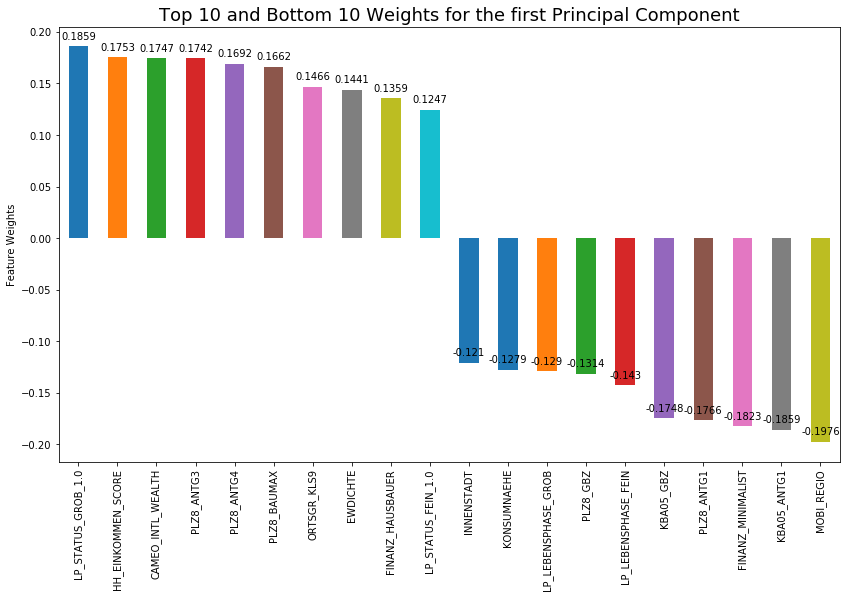

In [276]:
# Map weights for the first principal component to corresponding feature names
# and then print the linked values, sorted by weight.

pca_map_weights(pca, 1, general)

Explained variance for 1 Dimension - 0.0592 

Following are the linked values in sorted order (descending): 

ALTERSKATEGORIE_GROB            0.2339
FINANZ_VORSORGER                0.2124
ZABEOTYP_3.0                    0.1995
SEMIO_ERL                       0.1850
SEMIO_LUST                      0.1619
RETOURTYP_BK_S                  0.1573
W_KEIT_KIND_HH                  0.1304
CJT_GESAMTTYP_2.0               0.1038
LP_STATUS_FEIN_1.0              0.0939
FINANZTYP_5.0                   0.0930
FINANZ_MINIMALIST               0.0856
FINANZTYP_2.0                   0.0847
FINANZ_HAUSBAUER                0.0829
SEMIO_KRIT                      0.0817
SHOPPER_TYP_3.0                 0.0749
LP_FAMILIE_FEIN_1.0             0.0710
LP_FAMILIE_GROB_1.0             0.0710
CJT_GESAMTTYP_1.0               0.0687
NATIONALITAET_KZ_1.0            0.0674
PLZ8_ANTG3                      0.0658
FINANZTYP_6.0                   0.0651
EWDICHTE                        0.0628
ORTSGR_KLS9                     

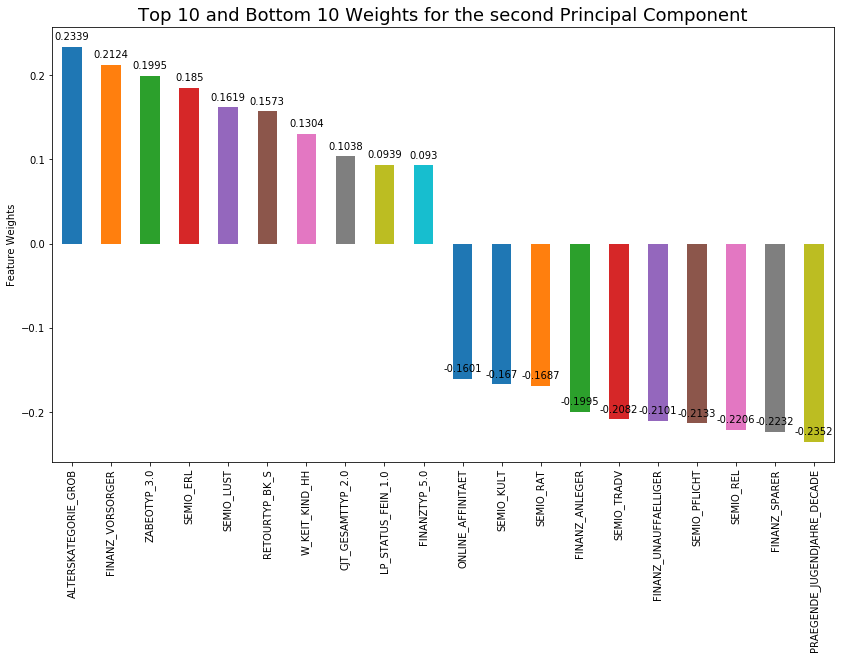

In [277]:
# Map weights for the second principal component to corresponding feature names
# and then print the linked values, sorted by weight.

pca_map_weights(pca, 2, general)

Explained variance for 1 Dimension - 0.0365 

Following are the linked values in sorted order (descending): 

SEMIO_VERT                        0.3140
SEMIO_FAM                         0.2514
SEMIO_SOZ                         0.2512
SEMIO_KULT                        0.2376
FINANZTYP_5.0                     0.1420
FINANZ_MINIMALIST                 0.1305
ZABEOTYP_1.0                      0.1239
SHOPPER_TYP_0.0                   0.1228
SEMIO_REL                         0.1143
GREEN_AVANTGARDE                  0.0990
PRAEGENDE_JUGENDJAHRE_MOVEMENT    0.0990
RETOURTYP_BK_S                    0.0817
EWDICHTE                          0.0817
ORTSGR_KLS9                       0.0811
SEMIO_MAT                         0.0784
LP_STATUS_GROB_5.0                0.0716
LP_STATUS_FEIN_10.0               0.0716
PLZ8_BAUMAX                       0.0579
W_KEIT_KIND_HH                    0.0577
PLZ8_ANTG4                        0.0572
PLZ8_ANTG3                        0.0566
LP_STATUS_FEIN_3.0           

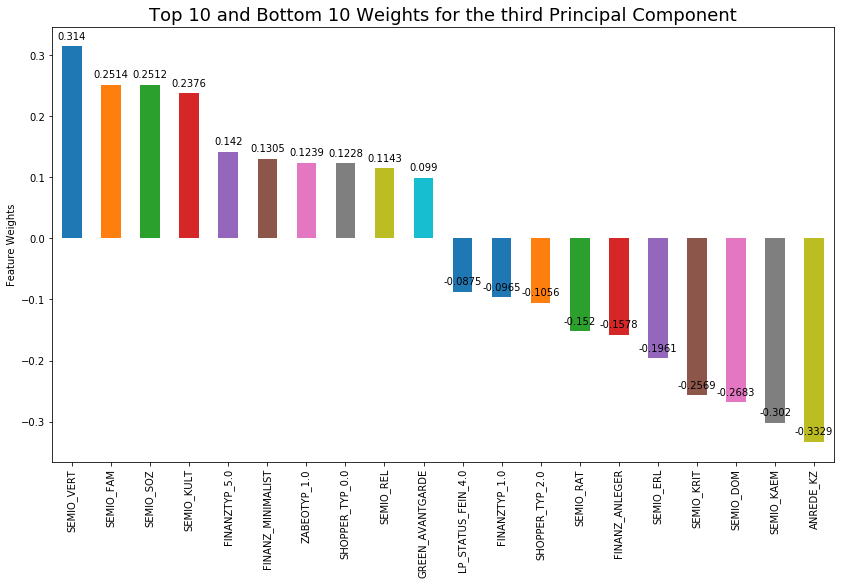

In [278]:
# Map weights for the third principal component to corresponding feature names
# and then print the linked values, sorted by weight.

pca_map_weights(pca, 3, general)

### Discussion 2.3: Interpret Principal Components

#### PCA1 - 
Positive feature weights: LP_STATUS_GROB_1.0, HH_EINKOMMEN_SCORE, CAMEO_INTL_WEALTH, PLZ8_ANTG3 and PLZ8_ANTG4 represents people with low income and high proportion of family homes

Negative feature weights: KBA05_GBZ, PLZ8_ANTG1, FINANZ_MINIMALIST, KBA05_ANTG1 and MOBI_REGIO represents people who frequently move places to earn money, small proportion of family homes and have low financial interest

#### PCA2 - 
Positive: ALTERSKATEGORIE_GROB and FINANZ_VORSORGER represents old people who have very less affinity to spent money on anything for which they are not prepared.

Negative: PRAEGENDE_JUGENDJAHRE_DECADE, FINANZ_SPARER, SEMIO_PFLICHT, SEMIO_REL represents people from 40s or 50s who are money saver, religious and dutiful.

#### PCA3-
Positive: SEMIO_VERT, SEMIO_FAM, SEMIO_SOZ, SEMIO_KULT represents people with less affinity towards family, dreams, society, culture etc.

Negative: ANREDE_KZ, SEMIO_KAEM, SEMIO_DOM, SEMIO_KRIT represents males with combative, dominant behaviour

## Step 3: Clustering

### Step 3.1: Apply Clustering to General Population

You've assessed and cleaned the demographics data, then scaled and transformed them. Now, it's time to see how the data clusters in the principal components space. In this substep, you will apply k-means clustering to the dataset and use the average within-cluster distances from each point to their assigned cluster's centroid to decide on a number of clusters to keep.

- Use sklearn's [KMeans](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans) class to perform k-means clustering on the PCA-transformed data.
- Then, compute the average difference from each point to its assigned cluster's center. **Hint**: The KMeans object's `.score()` method might be useful here, but note that in sklearn, scores tend to be defined so that larger is better. Try applying it to a small, toy dataset, or use an internet search to help your understanding.
- Perform the above two steps for a number of different cluster counts. You can then see how the average distance decreases with an increasing number of clusters. However, each additional cluster provides a smaller net benefit. Use this fact to select a final number of clusters in which to group the data. **Warning**: because of the large size of the dataset, it can take a long time for the algorithm to resolve. The more clusters to fit, the longer the algorithm will take. You should test for cluster counts through at least 10 clusters to get the full picture, but you shouldn't need to test for a number of clusters above about 30.
- Once you've selected a final number of clusters to use, re-fit a KMeans instance to perform the clustering operation. Make sure that you also obtain the cluster assignments for the general demographics data, since you'll be using them in the final Step 3.3.

In [279]:
# Over a number of different cluster counts...
# run k-means clustering on the data and...
# compute the average within-cluster distances.

scores = []
centroid = []

for i in range(1,15):
    kmeans = KMeans(i, random_state=0)
    model = kmeans.fit(general_pca_transform)
    scores.append(abs(model.score(general_pca_transform)))
    centroid.append(i)

print(scores)


[113465490.12381324, 105533877.37765156, 101818173.32103631, 99446481.3744412, 97524532.74347521, 96239856.63029595, 95208135.07263307, 94034979.38150153, 93474829.12267572, 92538462.5667756, 91723720.56379458, 91019101.86929195, 90788506.24328282, 90129830.88322414]


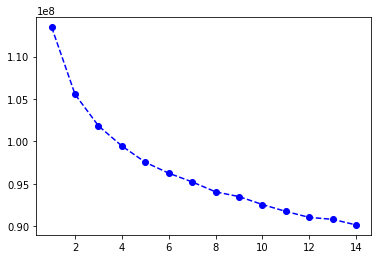

In [280]:
# Investigate the change in within-cluster distance across number of clusters.
# HINT: Use matplotlib's plot function to visualize this relationship.

plt.plot(centroid, scores, linestyle='--', marker ='o', color='b')

In [281]:
# Re-fit the k-means model with the selected number of clusters and obtain
# cluster predictions for the general population demographics data.

kmeans = KMeans(n_clusters= 4, random_state=0)
general_model = kmeans.fit(general_pca_transform)
general_predict = general_model.predict(general_pca_transform)

### Discussion 3.1: Apply Clustering to General Population

Based on the scree plot, I have decided to keep the clusters as 4 as these represents the people in each age category as per ALTERSKATEGORIE_GROB feature. For eg. Cluster 1 for 46-60 years, cluster 2 for 3-45 years etc

### Step 3.2: Apply All Steps to the Customer Data

Now that you have clusters and cluster centers for the general population, it's time to see how the customer data maps on to those clusters. Take care to not confuse this for re-fitting all of the models to the customer data. Instead, you're going to use the fits from the general population to clean, transform, and cluster the customer data. In the last step of the project, you will interpret how the general population fits apply to the customer data.

- Don't forget when loading in the customers data, that it is semicolon (`;`) delimited.
- Apply the same feature wrangling, selection, and engineering steps to the customer demographics using the `clean_data()` function you created earlier. (You can assume that the customer demographics data has similar meaning behind missing data patterns as the general demographics data.)
- Use the sklearn objects from the general demographics data, and apply their transformations to the customers data. That is, you should not be using a `.fit()` or `.fit_transform()` method to re-fit the old objects, nor should you be creating new sklearn objects! Carry the data through the feature scaling, PCA, and clustering steps, obtaining cluster assignments for all of the data in the customer demographics data.

In [282]:
# Load in the customer demographics data.
customers_df = pd.read_csv('Udacity_CUSTOMERS_Subset.csv', sep=';')
customers_df.head()

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,2,4,1,5.0,5,1,5,1,2,2,...,3.0,3.0,1.0,0.0,1.0,5.0,5.0,1.0,2.0,1.0
1,-1,4,1,NaN,5,1,5,1,3,2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,-1,4,2,2.0,5,1,5,1,4,4,...,2.0,3.0,3.0,1.0,3.0,3.0,2.0,3.0,5.0,3.0
3,1,4,1,2.0,5,1,5,2,1,2,...,3.0,2.0,1.0,0.0,1.0,3.0,4.0,1.0,3.0,1.0
4,-1,3,1,6.0,3,1,4,4,5,2,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,3.0,5.0,1.0


In [283]:
# Apply preprocessing, feature transformation, and clustering from the general
# demographics onto the customer data, obtaining cluster predictions for the
# customer demographics data.

customers = clean_data(customers_df, 'test', columns_deleted)
customers.head()

Following are the columns being dropped as they are having more than 30% NaN values
AGER_TYP
GEBURTSJAHR
TITEL_KZ
ALTER_HH
KK_KUNDENTYP
KBA05_BAUMAX
Threshold to divide the data into two subsets based on missing rows is 0
First subset is having 115643 rows and Second subset is having 76009 rows which is about 60.3400955899234 and 39.6599044100766 data respectively
Following table shows the count of each type of features

type
categorical    18
mixed           6
numeric         6
ordinal        49
Name: type, dtype: int64
-------------------------------------------------------------------

Following are the categorical featues

<class 'pandas.core.frame.DataFrame'>
Int64Index: 115643 entries, 0 to 191651
Data columns (total 18 columns):
ANREDE_KZ           115643 non-null float64
CJT_GESAMTTYP       115643 non-null float64
FINANZTYP           115643 non-null float64
GFK_URLAUBERTYP     115643 non-null float64
GREEN_AVANTGARDE    115643 non-null int64
LP_FAMILIE_FEIN     115643 non-null 

,ALTERSKATEGORIE_GROB,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,HEALTH_TYP,LP_LEBENSPHASE_FEIN,LP_LEBENSPHASE_GROB,...,CAMEO_DEU_2015_8D,CAMEO_DEU_2015_9A,CAMEO_DEU_2015_9B,CAMEO_DEU_2015_9C,CAMEO_DEU_2015_9D,CAMEO_DEU_2015_9E,PRAEGENDE_JUGENDJAHRE_DECADE,PRAEGENDE_JUGENDJAHRE_MOVEMENT,CAMEO_INTL_WEALTH,CAMEO_INTL_LIFE_STAGE
0,4.0,5.0,1.0,5.0,1.0,2.0,2.0,1.0,20.0,5.0,...,0,0,0,0,0,0,50.0,1.0,1,3
2,4.0,5.0,1.0,5.0,1.0,4.0,4.0,2.0,13.0,3.0,...,0,0,0,0,0,0,50.0,1.0,3,4
4,3.0,3.0,1.0,4.0,4.0,5.0,2.0,3.0,31.0,10.0,...,0,0,0,0,0,0,70.0,0.0,4,1
5,3.0,5.0,1.0,5.0,1.0,2.0,3.0,3.0,17.0,5.0,...,0,0,0,0,0,0,50.0,1.0,3,4
6,4.0,5.0,1.0,5.0,1.0,1.0,2.0,2.0,20.0,5.0,...,0,0,0,0,0,0,50.0,1.0,2,3


In [323]:
#Check if there is any column which does exists in cleaned general population dataset but does not exists in cleaned customer population and vice versa.

for i in general.columns:
    if i not in customers.columns:
        print(i, "does exists in general population but does not exists in customer dataset after cleaning")
for i in customers.columns:
    if i not in general.columns:
        print(i,"does exists in customer population but does not exists in general dataset after cleaning")
        
#Add the column into the customer population dataset
print("Need to add column GEBAEUDETYP_5.0 at {} position".format(customers.columns.get_loc('GEBAEUDETYP_3.0')+1))

GEBAEUDETYP_5 = [0] * customers.shape[0]
customers.insert(134,'GEBAEUDETYP_5.0',GEBAEUDETYP_5)


GEBAEUDETYP_5.0 does exists in general population but does not exists in customer dataset after cleaning
Need to add column GEBAEUDETYP_5.0 at 134 position


In [329]:
print("column has been added and new shape of the customer data is",customers.shape)

column has been added and new shape of the customer data is (115643, 193)


In [330]:
#perform the scaling, pca and prediction
customer_trans = scalar.transform(customers)
cust_pca_trans = pca.transform(customer_trans)
customer_predict = general_model.predict(cust_pca_trans)

### Step 3.3: Compare Customer Data to Demographics Data

At this point, you have clustered data based on demographics of the general population of Germany, and seen how the customer data for a mail-order sales company maps onto those demographic clusters. In this final substep, you will compare the two cluster distributions to see where the strongest customer base for the company is.

Consider the proportion of persons in each cluster for the general population, and the proportions for the customers. If we think the company's customer base to be universal, then the cluster assignment proportions should be fairly similar between the two. If there are only particular segments of the population that are interested in the company's products, then we should see a mismatch from one to the other. If there is a higher proportion of persons in a cluster for the customer data compared to the general population (e.g. 5% of persons are assigned to a cluster for the general population, but 15% of the customer data is closest to that cluster's centroid) then that suggests the people in that cluster to be a target audience for the company. On the other hand, the proportion of the data in a cluster being larger in the general population than the customer data (e.g. only 2% of customers closest to a population centroid that captures 6% of the data) suggests that group of persons to be outside of the target demographics.

Take a look at the following points in this step:

- Compute the proportion of data points in each cluster for the general population and the customer data. Visualizations will be useful here: both for the individual dataset proportions, but also to visualize the ratios in cluster representation between groups. Seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) or [`barplot()`](https://seaborn.pydata.org/generated/seaborn.barplot.html) function could be handy.
  - Recall the analysis you performed in step 1.1.3 of the project, where you separated out certain data points from the dataset if they had more than a specified threshold of missing values. If you found that this group was qualitatively different from the main bulk of the data, you should treat this as an additional data cluster in this analysis. Make sure that you account for the number of data points in this subset, for both the general population and customer datasets, when making your computations!
- Which cluster or clusters are overrepresented in the customer dataset compared to the general population? Select at least one such cluster and infer what kind of people might be represented by that cluster. Use the principal component interpretations from step 2.3 or look at additional components to help you make this inference. Alternatively, you can use the `.inverse_transform()` method of the PCA and StandardScaler objects to transform centroids back to the original data space and interpret the retrieved values directly.
- Perform a similar investigation for the underrepresented clusters. Which cluster or clusters are underrepresented in the customer dataset compared to the general population, and what kinds of people are typified by these clusters?

In [331]:
#Create a list so that it contains proportion of General population in each cluster w.r.to overall general population in the dataset
general_predict_prop = [round(len(general_predict[general_predict==i])/azdias.shape[0] * 100,2)  for i in range(0,4)]
#a new cluster has been added which has count of NaN values
general_predict_prop.append(round((azdias.shape[0]-len(general_predict))/azdias.shape[0] * 100,2))

#Create a list so that it contains proportion of Customer population in each cluster w.r.to overall customer population in the dataset
customer_predict_prop = [round(len(customer_predict[customer_predict==i])/customers_df.shape[0]  * 100,2)  for i in range(0,4)]
#a new cluster has been added which has count of NaN values
customer_predict_prop.append(round((customers_df.shape[0]-len(customer_predict))/customers_df.shape[0] * 100,2))

#This dataframe has 5 clusters - 4 are clusters retrived from K-means and 5th has been added for NaN values
cluster_prop = pd.DataFrame({'General_Prop':general_predict_prop, 'Customer_Prop':customer_predict_prop})
cluster_prop.index += 1 
cluster_prop

,General_Prop,Customer_Prop
1,12.69,30.01
2,17.60,1.21
3,19.30,15.45
4,20.34,13.68
5,30.07,39.66


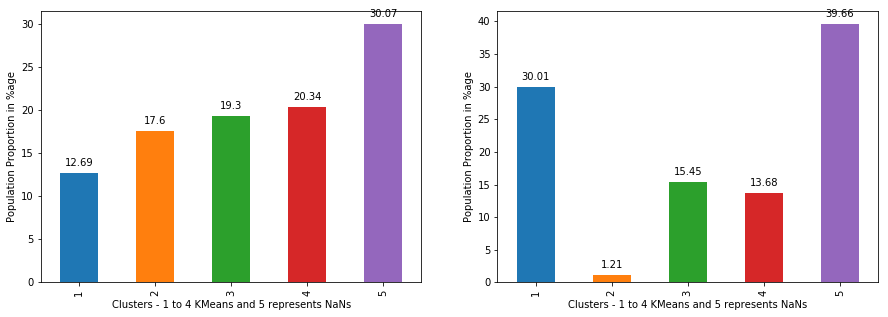

In [332]:
# Compare the proportion of data in each cluster for the customer data to the
# proportion of data in each cluster for the general population.
#Lets create a dataframe with 

fig, axr = plt.subplots(1,2, figsize=(15,5))

#ax = sns.countplot(,ax=axr[0])
ax1 = cluster_prop['General_Prop'].plot(kind='bar', ax=axr[0])
for p in ax1.patches:
        ax1.annotate(np.round(p.get_height(),decimals=4), (p.get_x()+p.get_width()/2., p.get_height()), ha='center', va='center', xytext=(0, 10), textcoords='offset points')
ax1.set_ylabel("Population Proportion in %age")
ax1.set_xlabel("Clusters - 1 to 4 KMeans and 5 represents NaNs")
#    t_text = 'Top 10 and Bottom 10 Weights for the ' +int2words(comp)+ ' Principal Component'
#    ax.set_title(t_text, fontsize=18)
ax2 = cluster_prop['Customer_Prop'].plot(kind='bar', ax=axr[1])
ax2.set_ylabel("Population Proportion in %age")
ax2.set_xlabel("Clusters - 1 to 4 KMeans and 5 represents NaNs")
for p in ax2.patches:
        ax2.annotate(np.round(p.get_height(),decimals=4), (p.get_x()+p.get_width()/2., p.get_height()), ha='center', va='center', xytext=(0, 10), textcoords='offset points')


In [333]:
general_inverse = pd.DataFrame(general_scalar_fit.inverse_transform(general_pca_fit.inverse_transform(general_model.cluster_centers_)))
general_inverse.columns = general.columns
general_inverse.index += 1
general_inverse

,ALTERSKATEGORIE_GROB,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,HEALTH_TYP,LP_LEBENSPHASE_FEIN,LP_LEBENSPHASE_GROB,...,CAMEO_DEU_2015_8D,CAMEO_DEU_2015_9A,CAMEO_DEU_2015_9B,CAMEO_DEU_2015_9C,CAMEO_DEU_2015_9D,CAMEO_DEU_2015_9E,PRAEGENDE_JUGENDJAHRE_DECADE,PRAEGENDE_JUGENDJAHRE_MOVEMENT,CAMEO_INTL_WEALTH,CAMEO_INTL_LIFE_STAGE
1,3.122649,4.360764,1.970530,3.906183,2.071397,2.425733,2.081901,2.105894,25.892284,7.566606,...,0.003566,0.003326,0.002797,0.001809,0.002155,0.001387,69.028519,0.951200,2.016463,3.646010
2,1.719889,1.551033,4.377139,2.075443,3.959277,3.817661,3.832719,2.272418,10.370350,3.427122,...,0.023953,0.054805,0.075605,0.065281,0.069070,0.002947,87.498564,0.092665,4.116370,2.257944
3,2.904384,3.763753,2.432475,3.553417,3.068940,2.443988,2.438123,2.236634,20.287623,6.069780,...,0.003449,0.006559,0.004429,0.002742,0.002579,0.000309,72.494135,0.048690,2.505610,3.285186
4,3.408974,2.879216,1.878180,4.262016,1.893603,1.675784,3.968340,2.187023,11.471409,3.549290,...,0.056925,0.036272,0.056778,0.053554,0.064398,0.015965,63.742980,0.086724,4.239474,2.541549


In [403]:
# What kinds of people are part of a cluster that is overrepresented in the
# customer data compared to the general population?
#Only cluster 1 has been overrepresented in the customer data compared to general data

overrepresent = general_inverse.loc[1]
print("Age Group",overrepresent['ALTERSKATEGORIE_GROB'])
print("Gender",overrepresent['ANREDE_KZ'])
print("Preferred information and buying channels",overrepresent['CJT_GESAMTTYP_4.0'])
print("Money saver",overrepresent['FINANZ_SPARER'])
print("home ownership",overrepresent['FINANZ_HAUSBAUER'])
print("Vacation habit",overrepresent['GFK_URLAUBERTYP_10.0'])
print("Life Stage",overrepresent['LP_LEBENSPHASE_FEIN'])
print("Nationality",overrepresent['NATIONALITAET_KZ_1.0'])
print('Shopper Type',overrepresent['SHOPPER_TYP_3.0'])
print("Household Net Income",overrepresent['HH_EINKOMMEN_SCORE'])
print("Number of households in the building",overrepresent['ANZ_HAUSHALTE_AKTIV'])
print("Neighborhood quality",overrepresent['WOHNLAGE'])
print("Online affinity",overrepresent['ONLINE_AFFINITAET'])

Age Group 3.1226488916573865
Gender 1.467337106205507
Preferred information and buying channels 0.2111393168025826
Money saver 1.9705295454441873
home ownership 2.081900608969148
Vacation habit 0.15344845337714075
Life Stage 25.892283783834586
Nationality 0.9497532771968433
Shopper Type 0.3209703423120491
Household Net Income 2.430460168783033
Number of households in the building 1.440916068444749
Neighborhood quality 3.299368491588238
Online affinity 3.3981312853532653


Cluster 1 represent people with names souding in Germans and in the age group of 46-60 years with almost mixed ratio of male and females. These people are interested in advertisement, prefer online shopping and they mostly go for shopping with family. These people have sufficient money to buy things and have vacation habits such as Connoisseurs, Nature fans and winter sportspeople. Most of them have their own houses and are independent families.
These people are somewhat more demanding while shopping and most of these families have very high income. Most of these families live in a separate house. Ideally Neighborhood quality should have been good so this variable should be investigate further.
Most of these people are very much online.

In [428]:
# What kinds of people are part of a cluster that is underrepresented in the
# customer data compared to the general population?

#cluster 2,3 and4 have been underrepresented in the customer data compared to general data but major difference in the 2nd cluster

underrepresent = general_inverse.loc[2]
print("Age Group",underrepresent['ALTERSKATEGORIE_GROB'])
print("Gender",underrepresent['ANREDE_KZ'])
print("Preferred information and buying channels", underrepresent['CJT_GESAMTTYP_4.0'])
print("Money saver",underrepresent['FINANZ_SPARER'])
print("home ownership",underrepresent['FINANZ_HAUSBAUER'])
print("Vacation habit",underrepresent['GFK_URLAUBERTYP_12.0'])
print("Life Stage",underrepresent['LP_LEBENSPHASE_FEIN'])
print("Nationality",underrepresent['NATIONALITAET_KZ_1.0'])
print('Shopper Type',underrepresent['SHOPPER_TYP_1.0'])
print("Household Net Income",underrepresent['HH_EINKOMMEN_SCORE'])
print("Number of households in the building",underrepresent['ANZ_HAUSHALTE_AKTIV'])
print("Neighborhood quality",underrepresent['WOHNLAGE'])
print("Online affinity",underrepresent['ONLINE_AFFINITAET'])


Age Group 1.7198892595002118
Gender 1.5341463675110714
Preferred information and buying channels 0.33786162213453974
Money saver 4.377139197002239
home ownership 3.832718851723129
Vacation habit 0.30144360930139347
Life Stage 10.370350339270617
Nationality 0.7217338259083039
Shopper Type 0.3471204438284031
Household Net Income 5.453156010460806
Number of households in the building 13.031282950745123
Neighborhood quality 3.614710376707676
Online affinity 3.151987373894952


Cluster 2 represent almostg 3/4th people with names souding in Germans and in the age group of 30-45 years with almost mixed ratio of male and females. These people are interested in advertisement and prefer online shopping. These people does not save money, do make very low investments and most of them do not go for vacations.

Most of these people are wealthy single homeowners and live in apartments. They are either stressed shoppers or like to go for shopping with family. Neighborhood quality is average to poor and online affinity is high.

### Discussion 3.3: Compare Customer Data to Demographics Data

(Double-click this cell and replace this text with your own text, reporting findings and conclusions from the clustering analysis. Can we describe segments of the population that are relatively popular with the mail-order company, or relatively unpopular with the company?)

As per the above analysis, people in cluster 1 are relatively popular with the mail-order company as these are wealthy people and like to go for shopping and vacations.

People in cluster2 are relatively unpopular with the company.

> Congratulations on making it this far in the project! Before you finish, make sure to check through the entire notebook from top to bottom to make sure that your analysis follows a logical flow and all of your findings are documented in **Discussion** cells. Once you've checked over all of your work, you should export the notebook as an HTML document to submit for evaluation. You can do this from the menu, navigating to **File -> Download as -> HTML (.html)**. You will submit both that document and this notebook for your project submission.